In [1]:
import numpy as np
from numpy.linalg import inv
import scipy as sci
from scipy.signal import place_poles, StateSpace, lsim
import matplotlib.pyplot as plt
from sim import *
pi = np.pi



In [2]:
## Define SS

RE = 6378 # km
ROrb = 300 # km
r0 = RE + ROrb
mu = 398600


A = np.array([[           0, 1, 0,                0],
                [3*mu/(r0**3), 0, 0, 2*np.sqrt(mu/r0)],
                [ 0, 0, 0, 1],
                [0, -2*np.sqrt(mu/r0**5), 0, 0 ]])

B = np.array([[0,0],
                [1,0],
                [0,0],
                [0,1/r0]])

C = np.array([[1,0,0,0],[0,0,1,0]])

D = np.zeros([2,2])

In [175]:
## Define Reference Input and Constant Disturbance force

# Period of orbit
T = 2*pi*np.sqrt(r0**3/mu)

# Define simulation time to be 3 orbital periods
tvec = np.linspace(0,3*T,round(30*T))

omega_des = np.sqrt(mu/(r0**3))
print(omega_des)


# Noise values
range_eta = 0.1 # m - 1 sigma
theta_eta = 0.0004 # rad - 1 sigma


0.0011569085351242237


In [176]:
np.set_printoptions(precision=2)
## Create Observer

# Check poles
# V,D = np.linalg.eig(A)
# for eig in V:
#     print(eig)

# print(D)

des_poles = np.array([-0.005, -0.01 + 0.001j, -0.01 - 0.001j, -0.02])
res = place_poles(np.transpose(A),np.transpose(C),des_poles)
L_T = res.gain_matrix
L = np.transpose(L_T)


In [177]:
## Steady state noise level
eta_vec = np.array([[range_eta],[theta_eta]])
ss_noise = L@eta_vec
print(ss_noise)

[[ 7.96e-03]
 [-3.15e-04]
 [-2.09e-05]
 [-2.65e-07]]


In [197]:
X0 = np.array([r0, 0, 0, omega_des])
dX0 = np.array([1, 0.005, 0.05, 0.0001])

X0_obj = X0 + dX0
res = 2000
null_U = lambda x: np.array([0,0])
null_Ur = lambda x, r: np.array([0,0])
X_sol_ref, t_sol = prop_orbit(X0, [0,2*T], null_Ur, mu, num_eval= res)
X_sol_obj, t_sol = prop_orbit(X0_obj, [0,2*T], null_Ur, mu, num_eval= res)


dX_sol = X_sol_obj - X_sol_ref
dX_sol_lin, t_sol = prop_orbit_linear(dX0, [0,2*T], null_U, mu, r0, num_eval= res)




In [198]:
dX_sol = X_sol_obj - X_sol_ref
dY_sol = np.vstack((dX_sol[0,:], dX_sol[2,:])) 
Y_noise = np.vstack((range_eta*np.random.randn(1,dX_sol.shape[1]), theta_eta*np.random.randn(1,dX_sol.shape[1])))
dY_meas = dY_sol + Y_noise

dX0_hat = np.array([dY_meas[0,0], 0, dY_meas[1,0], 0]).reshape((4,1))
dX0_hat

array([[1.02],
       [0.  ],
       [0.05],
       [0.  ]])

In [199]:
dY_meas[:,1]

array([0.95, 0.05])

In [200]:
def observe_func(dx_hat, u, y_meas, A, B, C, D, L):
    dx_hat = dx_hat.reshape((4,1))
    y_meas = y_meas.reshape((2,1))
    u = u.reshape((2,1))
    dx_hat_dot = A@dx_hat + B@u + L@((y_meas) - (C@dx_hat + D@u))
    return dx_hat_dot

dX_hat_sol = np.zeros(dX_sol.shape)
dX_hat = dX0_hat
for i in range(len(t_sol)):
    dt = np.mean(np.diff(t_sol))
    dX_hat_sol[:,i] = dX_hat.reshape(4)
    dX_hat = dt*observe_func(dX_hat, np.array([[0],[0]]), dY_meas[:,i], A, B, C, D, L) + dX_hat

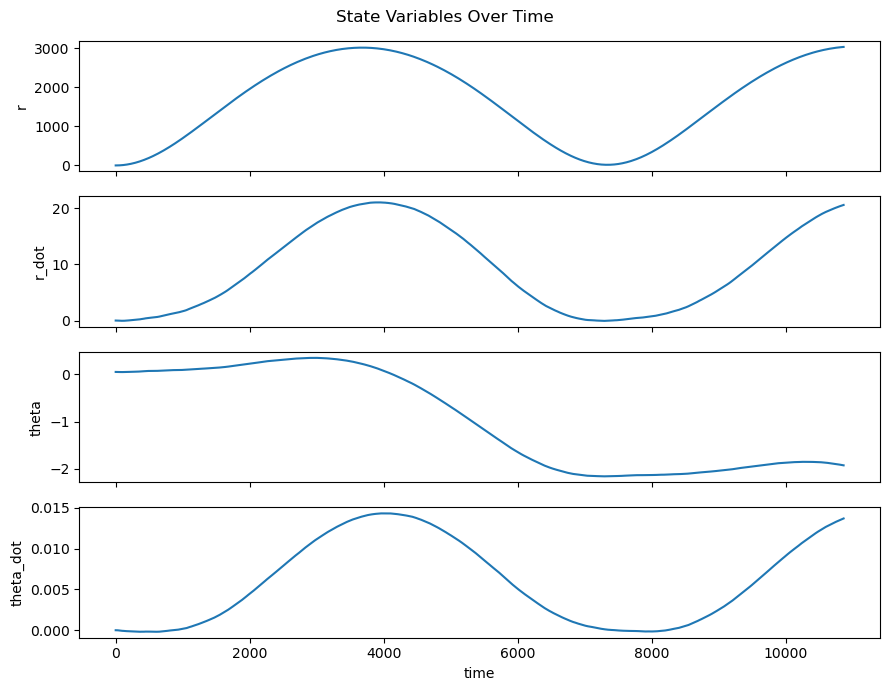

In [201]:
pl = plot_state(dX_hat_sol, t_sol)

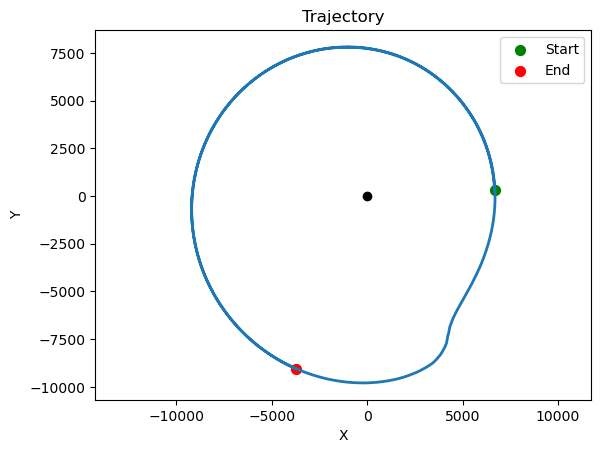

In [196]:
pl = plot_XY(X_sol_ref + dX_hat_sol)